In [1]:
# Import Libraries
import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
#from torchinfo import summary
import sys
# import netCDF4 as nc
#from prettytable import PrettyTable
import xarray as xr

2.0.0


In [2]:
torch.set_default_dtype(torch.float32)

In [3]:
rez = 500

In [4]:
data = xr.open_dataset('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/QBO_0.5x_100yrs_' + str(rez) + 'm.nc')
u = data.u[:-1, 1:-1].values
f = data.f[1:, 1:-1].values

In [5]:
#big data
trainset = TensorDataset(torch.from_numpy(u[:90*365]).float(),torch.from_numpy(f[:90*365]).float())
valset = TensorDataset(torch.from_numpy(u[90*365:]).float(),torch.from_numpy(f[90*365:]).float())

In [6]:
train_dataloader = DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=4)
val_dataloader  = DataLoader(valset, batch_size= len(valset), shuffle=True, num_workers=4)

In [7]:
data = xr.open_dataset('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/QBO_0.5x_1000yrs_' + str(rez) + 'm.nc')
u = data.u[:-1, 1:-1].values
f = data.f[1:, 1:-1].values

In [8]:
# u
testset = TensorDataset(torch.from_numpy(u).float(),torch.from_numpy(f).float())
test_dataloader  = DataLoader(testset, batch_size= len(testset), shuffle=False, num_workers=4)

In [9]:
# Set the device to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cpu')

In [11]:
class GlobalScaler():
    def __init__(self, X):
        self.abs_max = X.std().max() #(0)
        
    def transform(self, X):
        return X / self.abs_max
    
    def inverse_transform(self, X):
        return X * self.abs_max

In [27]:
# -------------------------------------------- FNO architecture -------------------------------------------- #
################################################################
#  1d Fourier Integral Operator
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width, time_future, time_history):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: a driving function observed at T timesteps + 1 locations (u(1, x), ..., u(T, x),  x).
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """
        self.modes = modes
        self.width = width
        self.time_future = time_future
        self.time_history = time_history
        self.fc0 = nn.Linear(self.time_history+1, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.time_future)

    def forward(self, u):
        grid = self.get_grid(u.shape, u.device)
        x = torch.cat((u, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

# -------------------------------------------- Model Parameters --------------------------------------------
time_history = 1 #time steps to be considered as input to the solver
time_future = 1 #time steps to be considered as output of the solver
# device = 'cuda'  #change to cpu of no cuda available

#Model parameters
modes = 9 #18 # 36 # number of Fourier modes to multiply
width = 37 # 37 # input and output channels to the FNO layer

num_epochs = 10 #set to one so faster computation, in principle 20 is best
learning_rate = 1e-4
lr_decay = 0.4
num_workers = 0

model = (FNO1d(modes, width, time_future, time_history)).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
# mynet.cuda()

loss = nn.MSELoss()
#use two optimizers.  learing rates seem to work.

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 5, 10, 15], gamma=lr_decay)

batch_size=1000

best_loss = 1e6
train_loss_list = []
test_loss_list = []

60012


In [28]:
print(model)

FNO1d(
  (fc0): Linear(in_features=2, out_features=37, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(37, 37, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(37, 37, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(37, 37, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(37, 37, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [29]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
            # save model
            torch.save(model.state_dict(), '/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/NNs/Model/FNO_4L_9M_w37_0.5x_' + str(rez) + 'm.pth')

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [30]:
# training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss = 0
    for batch, (X, Y) in enumerate(dataloader):
        
        X = X.unsqueeze(2)
        Y = Y.unsqueeze(2)
        
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred.float(), scaler_Y.transform(Y).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
        with torch.no_grad():
            avg_loss += loss.item()
            
    avg_loss /= len(dataloader)
    
    return avg_loss


# validating loop
def val_loop(dataloader, model, loss_fn):
    avg_loss = 0
    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            
            X = X.unsqueeze(2)
            Y = Y.unsqueeze(2)
            # Compute prediction and loss
            pred = model(X.float())
            loss = loss_fn(pred.float(), scaler_Y.transform(Y).float())
            avg_loss += loss.item()
            
    avg_loss /= len(dataloader)
    
    return avg_loss

In [31]:
train_losses = []
val_losses = []

In [32]:
learning_rate = 1e-2
epochs = 6000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler_Y = GlobalScaler(trainset[:][1])

In [33]:
scaler_Y.abs_max

tensor(2.9045e-06)

In [34]:
# training
k = 0
early_stopper = EarlyStopper(patience=30, min_delta=0.0)
for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, nn.MSELoss(), optimizer)
    train_losses.append(train_loss)
    val_loss = val_loop(val_dataloader, model, nn.MSELoss())
    val_losses.append(val_loss)
    if t % 10 ==0:
        print(f"Epoch {t+1}\n-------------------------------")
        print(val_loss)
        # print(train_loss)
    if early_stopper.early_stop(val_loss):
        if k <8:
            early_stopper = EarlyStopper(patience=40, min_delta=0.0)
            learning_rate = learning_rate * 0.25
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            k += 1
            print("New Learning Rate: " + str(learning_rate))
        else:
            break
print("Done!")

Epoch 1
-------------------------------
0.07789677381515503
Epoch 11
-------------------------------
0.005241008475422859
Epoch 21
-------------------------------
0.0049664718098938465
Epoch 31
-------------------------------
0.0019972282461822033
Epoch 41
-------------------------------
0.0015689849387854338
Epoch 51
-------------------------------
0.003038858063519001
Epoch 61
-------------------------------
0.0008700006292201579
Epoch 71
-------------------------------
0.001004741876386106
Epoch 81
-------------------------------
0.0012869128258898854
Epoch 91
-------------------------------
0.0011065389262512326
Epoch 101
-------------------------------
0.001808305736631155
New Learning Rate: 0.0025
Epoch 111
-------------------------------
0.0003677925851661712
Epoch 121
-------------------------------
0.00028082806966267526
Epoch 131
-------------------------------
0.00025873639970086515
Epoch 141
-------------------------------
0.000260197528405115
Epoch 151
--------------------

In [35]:
rez

500

In [36]:
model.load_state_dict(torch.load('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/NNs/Model/FNO_4L_9M_w37_0.5x_' + str(rez) + 'm.pth')) #_small_data_1.5yr

<All keys matched successfully>

In [37]:
with torch.no_grad():
    for batch, (X, Y) in enumerate(test_dataloader):
        X = X.unsqueeze(2)
        Y = Y.unsqueeze(2)
        pred = scaler_Y.inverse_transform(model(X)).squeeze()

In [38]:
f_array = xr.DataArray(pred, dims=('time', 'height'))
dataset = xr.Dataset({'f': (['time', 'height'], f_array.data, [('units', 'ms-2')])})
dataset.to_netcdf('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/NNs/Data/FNO_4L_9M_w37_0.5x_' + str(rez) + 'm_offline.nc')

In [39]:
(((pred - (test_dataloader.dataset[:][1]))**2).mean())**0.5

tensor(1.3163e-08)

In [40]:
(np.corrcoef(pred.flatten(), (test_dataloader.dataset[:][1]).flatten())[0][1])**2

0.9999792106644356

In [27]:
rez

225

In [96]:
for rez in [100, 125, 150, 200, 250, 300]:
        
    data = xr.open_dataset('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/QBO_0.5x_1000yrs_' + str(rez) + 'm.nc')
    u = data.u[:-1, 1:-1].values
    f = data.f[1:, 1:-1].values
    
    # u
    testset = TensorDataset(torch.from_numpy(u).float(),torch.from_numpy(f).float())
    test_dataloader  = DataLoader(testset, batch_size= len(testset), shuffle=False, num_workers=4)
    
    
    model.load_state_dict(torch.load('/glade/derecho/scratch/pahlavan/qbo1d/Nonlocality-0.5x/NNs/Model/FNO_4L_9M_w18_0.5x_' + str(rez) + 'm.pth')) #_small_data_1.5yr
    
    with torch.no_grad():
        for batch, (X, Y) in enumerate(test_dataloader):
            X = X.unsqueeze(2)
            Y = Y.unsqueeze(2)
            pred = scaler_Y.inverse_transform(model(X)).squeeze()
    
    print(rez)
    print((((pred - (test_dataloader.dataset[:][1]))**2).mean())**0.5)
    print((np.corrcoef(pred.flatten(), (test_dataloader.dataset[:][1]).flatten())[0][1])**2)
    print('#############')

100
tensor(7.4713e-08)
0.999478930516921
#############
125
tensor(5.7983e-08)
0.9997031986407212
#############
150
tensor(9.8826e-08)
0.9994983525174581
#############
200
tensor(1.3135e-07)
0.9999002767082766
#############
250
tensor(1.3665e-07)
0.99985217743488
#############
300
tensor(2.2001e-07)
0.9998124768074848
#############


In [48]:
grad = torch.zeros(35)
grad[17] = 1

grad_np = np.zeros((int(test_dataloader.dataset.tensors[0].shape[0]/100), test_dataloader.dataset.tensors[0].shape[1]))

for t in range(int(test_dataloader.dataset.tensors[0].shape[0]/100)):
    # input_ = Variable(test_dataloader.dataset.tensors[0][t][None, :], requires_grad=True)
    input_ = Variable(torch.rand(1, 35), requires_grad=True)
    out = model(input_.unsqueeze(2)).squeeze()
    out.backward(gradient=grad)
    grad_np[t]=input_.grad.data.numpy()[0]

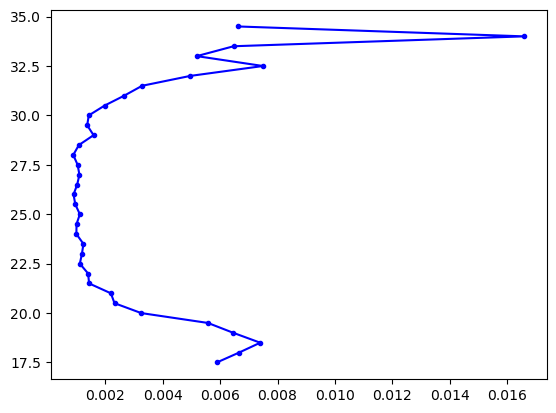

In [32]:
plt.plot(np.abs(grad_np).mean(0), np.arange(17.5, 35, 0.5), '-o', markersize=3, color='b')

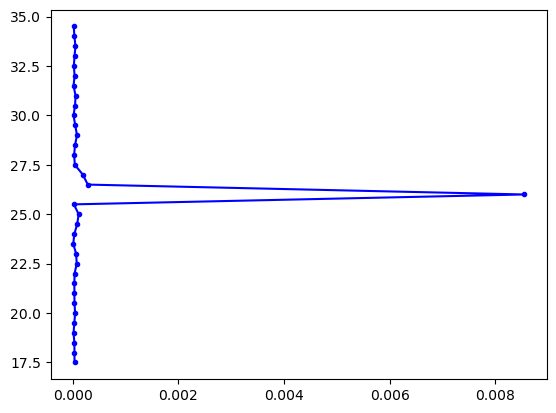

In [46]:
plt.plot(np.abs(grad_np).mean(0), np.arange(17.5, 35, 0.5), '-o', markersize=3, color='b')

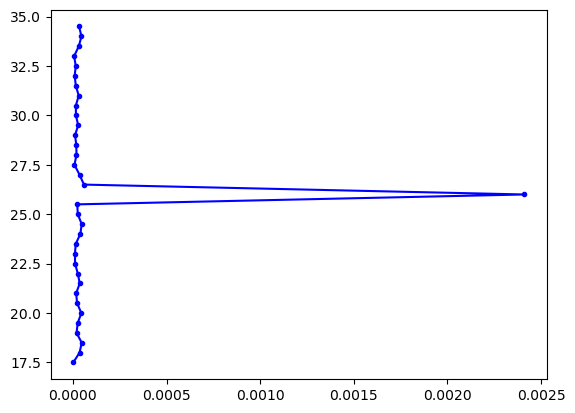

In [49]:
plt.plot(np.abs(grad_np).mean(0), np.arange(17.5, 35, 0.5), '-o', markersize=3, color='b')

In [27]:
import matplotlib.pyplot as plt